EPITA 2023 MLRF practice_05-01_image_classification v2023-06-11_215901 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 05 part 01: Image classification

## 0. Introduction

We will demonstrate how to build on the BoVW technique you implemented for the last session in order to recognize the category an image belongs to.

It consists in building a simple classifier using the BoVW descriptors which can be computed with the same method as the practice session 4.
However, you way want to seize this opportunity to improve the method you implemented, and maybe use a more powerful feature encoding technique, like the VLAD or even the Fisher Vector… Or extract better descriptors… Just make sure you **first complete a basic pipeline**, and select the **best possible classifier** for your encoding.


This session is inspired by this cool 2018 meme about animals which look like food:
![Cranberry muffins and chihuahuas](img/practice_05/meme_full.jpg)


In this session, you will learn how to produce results like the ones displayed below (first rows: chihuahuas, second rows: cranberry muffins, color and title indicates whether the classifier produced the right result).
![Sample output](img/practice_05/results.png)



We will proceed in 9 steps:

1. Load resources
2. Train a BoVW model
3. Split the dataset into training and validation sets
4. Compute the BoVW descriptor for each image
5. Prepare training structures
6. Train a classifier and evaluate its performance
7. Display some results
8. Test on meme images
9. Compute the results on the test set and export them

### 0.1 Resources
The resources for this session are stored on the network.

Here is a description of the files we provide in the student's archive:
- `meme_jpg/`: contains original meme images, for fun;
- `meme_siftgeo/`: contains SIFT descriptors of original meme images, for fun;
- `test_set_sift/`: contains the SIFT descriptors of the 400 test set images;
- `train_val_set_jpg/`: contains 2694 training and validation images for both classes:
   1416 for the "chihuahua" (`chi`) class, and 1278 for the "muffin" (`muf`) class;
- `train_val_set_siftgeo/`: contains the SIFT descriptors of the training and validation images
   for both classes;
- `sample_results.json`: an example of result file (with random results);
- `README.md`: even more details about the dataset.

**IMPORTANT:** the training set is **IMBALANCED** and you should take this into account before training
any classifier. The test set **is balanced**.


### 0.2 Ground truth format
The ground truth is implicit in this session: the files are stored in directories indicating the category they belong to. This is a very common practice among the various public dataset we can find.

### 0.3  Local descriptors
We provide precomputed SIFT descriptors to save you time.
We also provide a commodity function to help you loading them (see below), just like for the previous session.

# 1. Load resources

In [2]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn
import json

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Make sure the resources location below is correct.**
</div>

In [4]:
# setup the resources location
PATH_TO_RESOURCES = "/home/scott/epita/mlrf/tp5"

#TODO MAKE THE DATA BALANCED


### Code to read descriptors
We provide you with the function `siftgeo_read_desc(path)` which allows to get the array of descriptors stored in a `.siftgeo` file.

#### About the SIFT descriptors used (`.siftgeo` files)
Descriptors are stored in raw together with the region information provided by the software of Krystian Mikolajczyk.
There is no header (use the file length to find the number of descriptors).
A descriptor takes 168 bytes (floats and ints take 4 bytes, and are stored in little endian):
```
field      field type   description
x          float        horizontal position of the interest point
y          float        vertical position of the interest point
scale      float        scale of the interest region
angle      float        angle of the interest region
mi11       float        affine matrix component
mi12       float        affine matrix component
mi21       float        affine matrix component
mi22       float        affine matrix component
cornerness float        saliency of the interest point
desdim     int          dimension of the descriptors
component  byte*desdim  the descriptor vector (dd components)
```

In [5]:
SIFTGEO_DTYPE = np.dtype([
    ("x", "<f4"),
    ("y", "<f4"),
    ("scale", "<f4"),
    ("angle", "<f4"),
    ("mi11", "<f4"),
    ("mi12", "<f4"),
    ("mi21", "<f4"),
    ("mi22", "<f4"),
    ("cornerness", "<f4"),
    ("desdim", "<i4"),
    ("component", "<u1", 128)
])

def siftgeo_read_full(path):
    return np.fromfile(path, dtype=SIFTGEO_DTYPE)

def siftgeo_read_desc(path):
    if not path.endswith(".siftgeo"):
        raise ValueError("'path' parameter should end with '.siftgeo'.")
    desc = siftgeo_read_full(path)["component"]
    if desc.size == 0: 
        desc = np.zeros((0, 128), dtype = 'uint8')
    return desc

We prepare some list of files, for convenience.

In [6]:
# Using WINDOWS? (if not just remove this cell)
# ==============
# You may want to replace the commands below with something like:
# ALL_IMGS_CHI = !bash -c "ls $PATH_TO_RESOURCES/train_val_set_jpg/chi/*.jpg | sort"
# ...

In [7]:
# list of paths to training CHI images (only used for display)
ALL_IMGS_CHI = !ls $PATH_TO_RESOURCES/train_val_set_jpg/chi/*.jpg | sort
# list of paths to the training CHI descriptors for each image (same order)
ALL_SIFT_CHI = !ls $PATH_TO_RESOURCES/train_val_set_siftgeo/chi/*.siftgeo | sort
# list of paths to training MUF images (only used for display)
ALL_IMGS_MUF = !ls $PATH_TO_RESOURCES/train_val_set_jpg/muf/*.jpg | sort
# list of paths to the training MUF descriptors for each image (same order)
ALL_SIFT_MUF = !ls $PATH_TO_RESOURCES/train_val_set_siftgeo/muf/*.siftgeo | sort

In [8]:
ALL_SIFT_CHI[:5]

['/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0201.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0202.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0203.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0204.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0205.siftgeo']

In [9]:
ALL_SIFT_MUF[:5]

['/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0201.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0202.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0203.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0204.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0205.siftgeo']

## 2. Train a BoVW model
We want to assign a single vector to each image we will encounter.

We first need to build a BoVW model, exactly like during the previous session.

### 2.1 Select training descriptors
We need **some** descriptors from **every** classes!

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Select and load descriptors for 100 images of each category.**
</div>

In [10]:
import random
import numpy as np
# TODO select files to load
# Number of images to load from each category
num_images = 100

# Randomly select 100 descriptor files from each category
sample_descr_chi = random.sample(ALL_SIFT_CHI, num_images)

sample_descr_chi[:5]

['/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/1526.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0831.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/0907.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/1603.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/chi/1602.siftgeo']

In [11]:
# TODO select files to load
sample_descr_muf = random.sample(ALL_SIFT_MUF, num_images)
sample_descr_muf[:5]

['/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0545.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/1339.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0978.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0844.siftgeo',
 '/home/scott/epita/mlrf/tp5/train_val_set_siftgeo/muf/0549.siftgeo']

In [12]:
# TODO load descriptors as a list of np.array (each np.array contains the descriptors for an image)
train_desc = []
for desc_file in sample_descr_chi + sample_descr_muf:
    descriptors = siftgeo_read_desc(desc_file)
    train_desc.append(descriptors)
print(f"Number of images loaded: {len(train_desc)}")

Number of images loaded: 200


We now have a list of arrays of SIFT descriptors: for each image we have an array of shape `(number of descriptors, SIFT descriptor size)`.

We need to stack those descriptors to produce one big training array of shape `(total number of training descriptors, SIFT descriptor size)`.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Stack your descriptors to prepare your training set for the codebook generation.**
</div>

In [13]:
# TODO
# train_desc = ???
# train_desc.shape, train_desc.dtype

# Stack descriptors into a single array
train_desc = np.vstack(train_desc)

# Print shape and dtype of the array
print(f"Shape: {train_desc.shape}, Dtype: {train_desc.dtype}")



Shape: (84977, 128), Dtype: uint8


We got the following result from the previous cell:
`((83720, 128), dtype('uint8'))`

Finally, we convert this array to float32 elements to avoid normalization issues.

In [14]:
train_desc = train_desc.astype(np.float32)
# Print dtype of the array after conversion
print(f"Dtype after conversion: {train_desc.dtype}")

Dtype after conversion: float32


### 2.2 Learn normalization parameters and train a k-Means
We now need to perform some preprocessing on our data: centering and dimension reduction, before training our k-Means.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the mean of your sample and center your data.**
</div>

In [15]:
# TODO
# compute mean and center descriptors
train_mean = np.mean(train_desc, axis=0)
train_desc -= train_mean


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Learn a PCA transform to reduce the number of dimensions used.**
</div>

In [16]:
# compute PCA matrix and keep only 64 dimensions
train_cov = np.dot(train_desc.T, train_desc)
eigvals, eigvecs = np.linalg.eig(train_cov)
perm = eigvals.argsort()                   # sort by increasing eigenvalue
pca_transform = eigvecs[:, perm[64:128]]   # eigenvectors for the 64 last eigenvalues
pca_transform.shape, pca_transform.dtype

((128, 64), dtype('float32'))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Apply the PCA transform to your data.**
</div>

In [17]:
# TODO 
# transform sample with PCA (note that numpy imposes line-vectors,
# so we right-multiply the vectors)
train_desc = np.dot(train_desc, pca_transform)

In [18]:
# Check the shape of your new descriptors: we expect a shape like (BIGNUMBER, 64)
train_desc.shape

(84977, 64)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Train a k-Means with 512 dimensions to compute our codebook.**
</div>

In [19]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [22]:
# TODO
# fit k-means
# kmeans = ???

from sklearn.cluster import KMeans
import time, os, pickle
file_name = 'kmeans_results.pkl'

if os.path.exists(file_name):
    print("previous kmeans found")
    with open(file_name, 'rb') as file:
        try:
            kmeans = pickle.load(file)
        except pickle.UnpicklingError:
            print("Error while unpickling the file.")
else:
    print("File does not exist.")
    # Number of clusters
    k = 512
    start_time = time.time()
    # Fitting the k-Means model to the training descriptors
    kmeans = KMeans(n_clusters=k, random_state=0).fit(train_desc)

    # Checking the shape of the cluster centers
    print("--- %s seconds ---" % (time.time() - start_time))
    
    with open(file_name, 'wb') as file:
        pickle.dump(kmeans, file)

print(kmeans.cluster_centers_.shape)

previous kmeans found
(512, 64)


In [23]:
# let's check the shape of the cluster's centers
kmeans.cluster_centers_.shape

(512, 64)

We know have a codebook, and some learned parameters for preprocessing our data.

## 3. Split the dataset into training and validation sets
Before encoding our features, to avoid computing large arrays and splitting them afterhand (hence consuming much memory because of Python computation model), we will first separate the list of files into appropriate sublists for training and validating our model.

**But even before** we need to **make sure our dataset is balanced**!

Why? Well keep in mind that discriminant classifiers are very sensitive to class imbalance: if the density of elements is not the same for both classes, the decision boundary will be pushed toward the class with lower density because there will be less classification errors here!

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Transform the lists of files we previously defined to make sure our dataset is balanced.**
</div>

*Tip:* Here are the lists we previously defined:
- `ALL_IMGS_CHI`
- `ALL_SIFT_CHI`
- `ALL_IMGS_MUF`
- `ALL_SIFT_MUF`


In [24]:
len(ALL_IMGS_CHI), len(ALL_IMGS_MUF)

(1416, 1278)

In [25]:
# TODO
min_samples = min(len(ALL_IMGS_CHI), len(ALL_IMGS_MUF))
ALL_IMGS_CHI = ALL_IMGS_CHI[:min_samples]
ALL_SIFT_CHI = ALL_SIFT_CHI[:min_samples]
ALL_IMGS_MUF = ALL_IMGS_MUF[:min_samples]
ALL_SIFT_MUF = ALL_SIFT_MUF[:min_samples]

In [26]:
len(ALL_IMGS_CHI), len(ALL_IMGS_MUF)

(1278, 1278)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using Scikit learn function `sklearn.model_selection.train_test_split(...)`, separate the list of files we previously computed into two subsets each: a training set and a validation set.**
</div>

*Tip:* Here are the lists we previously defined:
- `ALL_IMGS_CHI`
- `ALL_SIFT_CHI`
- `ALL_IMGS_MUF`
- `ALL_SIFT_MUF`

We also want to split the list of images because it will be useful for visualizing the results.

You also may want to **specify the random state** to be able to reproduce your results.

In [27]:
# TODO
# train / validation split
# (train_imgs_chi, val_imgs_chi,
#  train_sift_chi, val_sift_chi,
#  train_imgs_muf, val_imgs_muf,
#  train_sift_muf, val_sift_muf) = sklearn.model_selection.train_test_split(
#     ???
# )

from sklearn.model_selection import train_test_split

# define a seed for reproducibility
seed = 42

# split CHI data
train_imgs_chi, val_imgs_chi = train_test_split(ALL_IMGS_CHI, test_size=0.2, random_state=seed)
train_sift_chi, val_sift_chi = train_test_split(ALL_SIFT_CHI, test_size=0.2, random_state=seed)

# split MUF data
train_imgs_muf, val_imgs_muf = train_test_split(ALL_IMGS_MUF, test_size=0.2, random_state=seed)
train_sift_muf, val_sift_muf = train_test_split(ALL_SIFT_MUF, test_size=0.2, random_state=seed)

In [28]:
len(train_sift_chi), len(val_sift_chi), len(train_sift_muf), len(val_sift_muf)

(1022, 256, 1022, 256)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**According to you, why do we call our sets "training" and "validation", and not "training" and "testing"?**
</div>

Well the training set is the data on which the model is trained, where it learns the patterns in the data. 
The validation dataset is used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. It's used as a guide to how you may want to model your model. 
The test set is not used during the creation of the model and only provides a final measurement of the model's perofrmance.

## 4. Compute the BoVW descriptor for each image
We can now encode the local SIFT descriptors of each image using the elements we learned.

Like in the previous session, we will compte a single descriptor of dimension `512` (or something else if you changed the size of the coodebook).

We will however add a couple of improvements over the version used during the last session: 
1. we will project our descriptor to another embedding space using the square root, to simulate an Hellinger kernel;
2. we will perform a L2 normalization of the final descriptor to facilitate linear classification.

We first import an appropriate normalizer for L2, to avoid little programming mistakes.

In [29]:
l2_normalizer = sklearn.preprocessing.Normalizer(norm='l2', copy=True)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the function below which takes a list of `.siftgeo` files, a training mean, a PCA transform, and a k-Means object and compute the arrays of BoVW descriptors, one for each `.siftgeo` file.**
</div>

In [30]:
# TODO
from collections import Counter
from sklearn.preprocessing import normalize
def compute_descriptors(siftgeo_filelist, train_mean, pca_transform, kmeans):
    """
    Parameters
    ----------
    siftgeo_filelist: list of len `num_files`
        List of paths to SIFTGEO files
    train_mean: np.array of shape (descr_size, )
        Mean value of the descriptor space (previously learned)
    pca_transform: np.array of shape (descr_size, final_dim)
        Matrix of the projection transform from the original descriptor space to the final space
    kmeans: sklearn.MiniBatchKMeans witk `n_clusters` centroids
        KMeans object with a `predict` method
        
    Returns
    -------
    image_descriptors: np.array of size (num_files, n_clusters)
        Global descriptor computed from each original SIFTGEO file (set of local descriptors).
    """
    image_descriptors = np.zeros((len(siftgeo_filelist), kmeans.n_clusters), dtype=np.float32)
    
    for ii, descrfile in enumerate(siftgeo_filelist):
        shortname = descrfile.split('/')[-2:]
        print("Indexing %s" % (shortname,))
        # read the descriptors
        desc = siftgeo_read_desc(descrfile)
        if desc.shape[0] == 0:
            # let the descriptor be 0 for all values
            # note that this is bad and the element should be dropped from the index
            print("WARNING: zero descriptor for %s" % (shortname,))
            continue
        
        # convert to float
        desc = desc.astype(np.float32)
        
# center and apply PCA transform
        desc -= train_mean
        desc = np.dot(desc, pca_transform)
        
        # get cluster ids
        clabels = kmeans.predict(desc)
        
        # compute histogram
        counter = Counter(clabels)
        descr_hist = [counter[i] for i in range(kmeans.n_clusters)]
        
        # l1 norm
        descr_hist = normalize([descr_hist], norm='l1')[0]
        
        # take the sqrt (Hellinger kernel)
        descr_hist = np.sqrt(descr_hist)
        
        # l2 norm
        descr_hist = normalize([descr_hist], norm='l2')[0]
        
        # update the index
        image_descriptors[ii] = descr_hist
    print("Indexing complete.")
    return image_descriptors

**We can now computes the descriptors for each subset.**

Let us just run the previously-defined function in batch.

In [31]:
x_train_chi, x_val_chi, x_train_muf, x_val_muf = [
    compute_descriptors(filelist, train_mean, pca_transform, kmeans) 
    for filelist in (train_sift_chi, val_sift_chi,
                     train_sift_muf, val_sift_muf)]

Indexing ['chi', '1053.siftgeo']
Indexing ['chi', '0928.siftgeo']
Indexing ['chi', '0359.siftgeo']
Indexing ['chi', '0552.siftgeo']
Indexing ['chi', '1309.siftgeo']
Indexing ['chi', '1297.siftgeo']
Indexing ['chi', '0532.siftgeo']
Indexing ['chi', '0626.siftgeo']
Indexing ['chi', '0986.siftgeo']
Indexing ['chi', '1044.siftgeo']
Indexing ['chi', '0297.siftgeo']
Indexing ['chi', '1192.siftgeo']
Indexing ['chi', '0471.siftgeo']
Indexing ['chi', '1174.siftgeo']
Indexing ['chi', '0357.siftgeo']
Indexing ['chi', '0823.siftgeo']
Indexing ['chi', '1426.siftgeo']
Indexing ['chi', '0780.siftgeo']
Indexing ['chi', '1386.siftgeo']
Indexing ['chi', '0616.siftgeo']
Indexing ['chi', '0564.siftgeo']
Indexing ['chi', '0753.siftgeo']
Indexing ['chi', '0629.siftgeo']
Indexing ['chi', '0715.siftgeo']
Indexing ['chi', '0668.siftgeo']
Indexing ['chi', '1341.siftgeo']
Indexing ['chi', '1013.siftgeo']
Indexing ['chi', '1258.siftgeo']
Indexing ['chi', '1333.siftgeo']
Indexing ['chi', '0790.siftgeo']
Indexing [

Indexing ['chi', '0915.siftgeo']
Indexing ['chi', '0281.siftgeo']
Indexing ['chi', '1159.siftgeo']
Indexing ['chi', '0742.siftgeo']
Indexing ['chi', '0681.siftgeo']
Indexing ['chi', '0366.siftgeo']
Indexing ['chi', '0449.siftgeo']
Indexing ['chi', '0508.siftgeo']
Indexing ['chi', '1070.siftgeo']
Indexing ['chi', '1029.siftgeo']
Indexing ['chi', '0535.siftgeo']
Indexing ['chi', '0298.siftgeo']
Indexing ['chi', '1339.siftgeo']
Indexing ['chi', '0921.siftgeo']
Indexing ['chi', '1117.siftgeo']
Indexing ['chi', '1062.siftgeo']
Indexing ['chi', '0982.siftgeo']
Indexing ['chi', '1318.siftgeo']
Indexing ['chi', '1356.siftgeo']
Indexing ['chi', '0503.siftgeo']
Indexing ['chi', '1248.siftgeo']
Indexing ['chi', '0589.siftgeo']
Indexing ['chi', '0436.siftgeo']
Indexing ['chi', '1125.siftgeo']
Indexing ['chi', '1009.siftgeo']
Indexing ['chi', '0506.siftgeo']
Indexing ['chi', '1256.siftgeo']
Indexing ['chi', '1238.siftgeo']
Indexing ['chi', '0450.siftgeo']
Indexing ['chi', '1291.siftgeo']
Indexing [

Indexing ['chi', '0756.siftgeo']
Indexing ['chi', '0243.siftgeo']
Indexing ['chi', '0368.siftgeo']
Indexing ['chi', '0617.siftgeo']
Indexing ['chi', '0777.siftgeo']
Indexing ['chi', '0468.siftgeo']
Indexing ['chi', '1123.siftgeo']
Indexing ['chi', '0627.siftgeo']
Indexing ['chi', '0891.siftgeo']
Indexing ['chi', '0745.siftgeo']
Indexing ['chi', '1398.siftgeo']
Indexing ['chi', '0875.siftgeo']
Indexing ['chi', '0890.siftgeo']
Indexing ['chi', '1326.siftgeo']
Indexing ['chi', '1452.siftgeo']
Indexing ['chi', '0360.siftgeo']
Indexing ['chi', '1214.siftgeo']
Indexing ['chi', '0458.siftgeo']
Indexing ['chi', '1168.siftgeo']
Indexing ['chi', '0536.siftgeo']
Indexing ['chi', '1189.siftgeo']
Indexing ['chi', '0216.siftgeo']
Indexing ['chi', '0716.siftgeo']
Indexing ['chi', '0525.siftgeo']
Indexing ['chi', '0969.siftgeo']
Indexing ['chi', '0808.siftgeo']
Indexing ['chi', '1325.siftgeo']
Indexing ['chi', '1101.siftgeo']
Indexing ['chi', '1040.siftgeo']
Indexing ['chi', '0423.siftgeo']
Indexing [

Indexing ['chi', '0352.siftgeo']
Indexing ['chi', '0604.siftgeo']
Indexing ['chi', '0408.siftgeo']
Indexing ['chi', '1410.siftgeo']
Indexing ['chi', '0209.siftgeo']
Indexing ['chi', '1215.siftgeo']
Indexing ['chi', '1261.siftgeo']
Indexing ['chi', '0653.siftgeo']
Indexing ['chi', '0454.siftgeo']
Indexing ['chi', '1097.siftgeo']
Indexing ['chi', '1319.siftgeo']
Indexing ['chi', '1081.siftgeo']
Indexing ['chi', '1408.siftgeo']
Indexing ['chi', '0824.siftgeo']
Indexing ['chi', '0546.siftgeo']
Indexing ['chi', '1300.siftgeo']
Indexing ['chi', '0463.siftgeo']
Indexing ['chi', '0351.siftgeo']
Indexing ['chi', '0673.siftgeo']
Indexing ['chi', '0841.siftgeo']
Indexing ['chi', '1467.siftgeo']
Indexing ['chi', '1405.siftgeo']
Indexing ['chi', '0751.siftgeo']
Indexing ['chi', '1129.siftgeo']
Indexing ['chi', '0689.siftgeo']
Indexing ['chi', '1391.siftgeo']
Indexing ['chi', '0347.siftgeo']
Indexing ['chi', '0603.siftgeo']
Indexing ['chi', '1155.siftgeo']
Indexing ['chi', '1400.siftgeo']
Indexing [

Indexing ['chi', '0907.siftgeo']
Indexing ['chi', '1436.siftgeo']
Indexing ['chi', '1472.siftgeo']
Indexing ['chi', '0490.siftgeo']
Indexing ['chi', '0759.siftgeo']
Indexing ['chi', '0831.siftgeo']
Indexing ['chi', '0547.siftgeo']
Indexing ['chi', '0800.siftgeo']
Indexing ['chi', '0559.siftgeo']
Indexing ['chi', '1207.siftgeo']
Indexing ['chi', '1276.siftgeo']
Indexing ['chi', '0497.siftgeo']
Indexing ['chi', '1120.siftgeo']
Indexing ['chi', '0811.siftgeo']
Indexing ['chi', '0440.siftgeo']
Indexing ['chi', '1133.siftgeo']
Indexing ['chi', '0409.siftgeo']
Indexing ['chi', '1021.siftgeo']
Indexing ['chi', '0233.siftgeo']
Indexing ['chi', '0683.siftgeo']
Indexing ['chi', '0786.siftgeo']
Indexing ['chi', '0672.siftgeo']
Indexing ['chi', '1429.siftgeo']
Indexing ['chi', '1474.siftgeo']
Indexing ['chi', '1255.siftgeo']
Indexing ['chi', '1418.siftgeo']
Indexing ['chi', '0422.siftgeo']
Indexing ['chi', '1444.siftgeo']
Indexing ['chi', '0767.siftgeo']
Indexing ['chi', '0855.siftgeo']
Indexing [

Indexing ['muf', '0425.siftgeo']
Indexing ['muf', '0979.siftgeo']
Indexing ['muf', '0475.siftgeo']
Indexing ['muf', '0524.siftgeo']
Indexing ['muf', '0640.siftgeo']
Indexing ['muf', '1388.siftgeo']
Indexing ['muf', '0694.siftgeo']
Indexing ['muf', '0624.siftgeo']
Indexing ['muf', '1440.siftgeo']
Indexing ['muf', '0953.siftgeo']
Indexing ['muf', '1364.siftgeo']
Indexing ['muf', '0595.siftgeo']
Indexing ['muf', '1060.siftgeo']
Indexing ['muf', '0955.siftgeo']
Indexing ['muf', '1316.siftgeo']
Indexing ['muf', '1299.siftgeo']
Indexing ['muf', '0850.siftgeo']
Indexing ['muf', '0735.siftgeo']
Indexing ['muf', '0652.siftgeo']
Indexing ['muf', '0968.siftgeo']
Indexing ['muf', '0867.siftgeo']
Indexing ['muf', '0522.siftgeo']
Indexing ['muf', '0729.siftgeo']
Indexing ['muf', '0917.siftgeo']
Indexing ['muf', '1253.siftgeo']
Indexing ['muf', '1007.siftgeo']
Indexing ['muf', '0240.siftgeo']
Indexing ['muf', '0231.siftgeo']
Indexing ['muf', '0443.siftgeo']
Indexing ['muf', '1066.siftgeo']
Indexing [

Indexing ['muf', '0830.siftgeo']
Indexing ['muf', '1163.siftgeo']
Indexing ['muf', '0558.siftgeo']
Indexing ['muf', '0530.siftgeo']
Indexing ['muf', '1251.siftgeo']
Indexing ['muf', '1148.siftgeo']
Indexing ['muf', '0459.siftgeo']
Indexing ['muf', '1194.siftgeo']
Indexing ['muf', '1420.siftgeo']
Indexing ['muf', '1149.siftgeo']
Indexing ['muf', '0878.siftgeo']
Indexing ['muf', '1147.siftgeo']
Indexing ['muf', '0726.siftgeo']
Indexing ['muf', '1375.siftgeo']
Indexing ['muf', '0944.siftgeo']
Indexing ['muf', '1056.siftgeo']
Indexing ['muf', '1461.siftgeo']
Indexing ['muf', '0641.siftgeo']
Indexing ['muf', '0732.siftgeo']
Indexing ['muf', '0427.siftgeo']
Indexing ['muf', '0429.siftgeo']
Indexing ['muf', '1342.siftgeo']
Indexing ['muf', '0413.siftgeo']
Indexing ['muf', '0280.siftgeo']
Indexing ['muf', '0349.siftgeo']
Indexing ['muf', '0869.siftgeo']
Indexing ['muf', '1004.siftgeo']
Indexing ['muf', '1139.siftgeo']
Indexing ['muf', '0334.siftgeo']
Indexing ['muf', '1091.siftgeo']
Indexing [

Indexing ['muf', '1030.siftgeo']
Indexing ['muf', '0317.siftgeo']
Indexing ['muf', '0674.siftgeo']
Indexing ['muf', '0941.siftgeo']
Indexing ['muf', '1280.siftgeo']
Indexing ['muf', '0258.siftgeo']
Indexing ['muf', '0804.siftgeo']
Indexing ['muf', '0987.siftgeo']
Indexing ['muf', '1031.siftgeo']
Indexing ['muf', '0320.siftgeo']
Indexing ['muf', '0857.siftgeo']
Indexing ['muf', '1228.siftgeo']
Indexing ['muf', '0870.siftgeo']
Indexing ['muf', '0306.siftgeo']
Indexing ['muf', '0836.siftgeo']
Indexing ['muf', '0570.siftgeo']
Indexing ['muf', '0469.siftgeo']
Indexing ['muf', '0856.siftgeo']
Indexing ['muf', '1020.siftgeo']
Indexing ['muf', '1023.siftgeo']
Indexing ['muf', '1166.siftgeo']
Indexing ['muf', '0247.siftgeo']
Indexing ['muf', '0550.siftgeo']
Indexing ['muf', '1304.siftgeo']
Indexing ['muf', '1077.siftgeo']
Indexing ['muf', '0974.siftgeo']
Indexing ['muf', '0396.siftgeo']
Indexing ['muf', '0303.siftgeo']
Indexing ['muf', '0205.siftgeo']
Indexing ['muf', '0820.siftgeo']
Indexing [

Indexing ['muf', '1221.siftgeo']
Indexing ['muf', '0764.siftgeo']
Indexing ['muf', '0943.siftgeo']
Indexing ['muf', '1064.siftgeo']
Indexing ['muf', '1092.siftgeo']
Indexing ['muf', '1239.siftgeo']
Indexing ['muf', '0407.siftgeo']
Indexing ['muf', '0593.siftgeo']
Indexing ['muf', '0995.siftgeo']
Indexing ['muf', '1071.siftgeo']
Indexing ['muf', '0598.siftgeo']
Indexing ['muf', '0967.siftgeo']
Indexing ['muf', '1372.siftgeo']
Indexing ['muf', '1229.siftgeo']
Indexing ['muf', '0843.siftgeo']
Indexing ['muf', '0813.siftgeo']
Indexing ['muf', '1161.siftgeo']
Indexing ['muf', '0926.siftgeo']
Indexing ['muf', '0884.siftgeo']
Indexing ['muf', '0299.siftgeo']
Indexing ['muf', '1005.siftgeo']
Indexing ['muf', '0607.siftgeo']
Indexing ['muf', '0703.siftgeo']
Indexing ['muf', '1272.siftgeo']
Indexing ['muf', '1257.siftgeo']
Indexing ['muf', '1130.siftgeo']
Indexing ['muf', '0980.siftgeo']
Indexing ['muf', '0401.siftgeo']
Indexing ['muf', '0335.siftgeo']
Indexing ['muf', '1252.siftgeo']
Indexing [

Indexing ['muf', '1345.siftgeo']
Indexing ['muf', '1197.siftgeo']
Indexing ['muf', '1346.siftgeo']
Indexing ['muf', '0230.siftgeo']
Indexing ['muf', '1048.siftgeo']
Indexing ['muf', '0999.siftgeo']
Indexing ['muf', '0232.siftgeo']
Indexing ['muf', '0498.siftgeo']
Indexing ['muf', '0938.siftgeo']
Indexing ['muf', '0455.siftgeo']
Indexing ['muf', '0271.siftgeo']
Indexing ['muf', '1374.siftgeo']
Indexing ['muf', '0913.siftgeo']
Indexing ['muf', '1234.siftgeo']
Indexing ['muf', '1090.siftgeo']
Indexing ['muf', '0460.siftgeo']
Indexing ['muf', '1263.siftgeo']
Indexing ['muf', '1027.siftgeo']
Indexing ['muf', '0733.siftgeo']
Indexing ['muf', '0249.siftgeo']
Indexing ['muf', '0314.siftgeo']
Indexing ['muf', '0591.siftgeo']
Indexing ['muf', '0582.siftgeo']
Indexing ['muf', '0478.siftgeo']
Indexing ['muf', '1469.siftgeo']
Indexing ['muf', '1015.siftgeo']
Indexing ['muf', '1014.siftgeo']
Indexing ['muf', '0308.siftgeo']
Indexing ['muf', '1198.siftgeo']
Indexing ['muf', '1421.siftgeo']
Indexing [

## 5. Prepare training structures

To train our classifier, we need to prepare two structures:
- a `X` array containing of shape `(n_samples, n_features)`;
- a `y` array containing the target values to predict.

### Representation of Data in Scikit-learn

Machine learning is about creating models from data: for that reason, we'll start by
discussing how data can be represented in order to be understood by the computer.  Along
with this, we'll build on our matplotlib examples from the previous section and show some
examples of how to visualize data.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case
where `scipy.sparse` matrices can be useful, in that they are
much more memory-efficient than numpy arrays.

![Data Layout](img/practice_05/data-layout.png)

(From the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create the "X" training vector using the previously generated descriptors.**
</div>

*Tip:* Its is just about stacking `x_train_chi` and `x_train_muf`!

In [42]:
x_train_chi_sparse = sp.csr_matrix(x_train_chi)
x_train_muf_sparse = sp.csr_matrix(x_train_muf)

# Stack the sparse matrices
x_train = sp.vstack([x_train_chi_sparse, x_train_muf_sparse])

print(x_train_sparse.shape)

#MAKING SURE TO USE SPARSE matrices and not np.arrays

(2044, 512)


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create the "y" training vector. It is slightly trickier: we will create a vector of shape `(n_images, )` with `0`s for elements belonging to the first class (`chi`), and `1`s for elements belonging to the second class (`muf`).**
</div>

*Tip:* Our dataset is balanced and we created our `x_train` vector in such way that the first half of the samples belong to the first category, and the second half to the other one!

In [48]:
n_samples = x_train.shape[0]
n_samples_per_class = n_samples // 2  # // is the integer division operator

# Create a numpy array filled with 0s for the first class and 1s for the second class
y_train = np.hstack([np.zeros(n_samples_per_class, dtype=int), 
                     np.ones(n_samples - n_samples_per_class, dtype=int)])

print(y_train.shape)


(2044,)


In [45]:
# Sanity check: count the number of elements in the second class
np.sum(y_train)

1022

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Conversely, create the validation source and target vectors which will allow us to measure the performance of our classifier.**
</div>

In [46]:
x_val_chi_sparse = sp.csr_matrix(x_val_chi)
x_val_muf_sparse = sp.csr_matrix(x_val_muf)

# Stack the sparse matrices
x_val = sp.vstack([x_val_chi_sparse, x_val_muf_sparse])

print(x_val.shape)


(512, 512)


In [47]:
# TODO
# For the target vectors, the first half of the samples belong to the first category 
# and the second half belong to the second category
n_samples_val = x_val.shape[0]
n_samples_per_class_val = n_samples_val // 2  # integer division

# Create a numpy array filled with 0s for the first class and 1s for the second class
y_val = np.hstack([np.zeros(n_samples_per_class_val, dtype=int), 
                   np.ones(n_samples_val - n_samples_per_class_val, dtype=int)])
y_val.shape

(512,)

## 6. Train a classifier and evaluate its performance
We are now ready to enjoy the beauty of Scikit-learn: we will create a simple linear SVM with default values, train it and evaluate its performance.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Create a simple linear SVM classifier.**
</div>

In [49]:
# TODO create your classifier
from sklearn import svm
clf = svm.LinearSVC()

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Train your classifier using `x_train` and `y_train`.**
</div>

In [50]:
# Train the classifier
clf.fit(x_train, y_train)

LinearSVC()

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now evaluate the performance of your classifier using one of its builtin methods. Which "X" and "y" are you going to use? What is the measure we obtain?**
</div>

In [51]:
# TODO evaluate the performance of your classifier on the VALIDATION set
score_val = clf.score(x_val, y_val)
print("Validation accuracy: ", score_val)

Validation accuracy:  0.748046875


With a basic BoVW implementation, we obtained around 70% accuracy on a validation set.

Keep in mind that the dataset is noisy and that the accuracy on the test set may be quite different.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compare the score you obtained on the validation set with the one on the training set. What does this reveal?**
</div>

In [52]:
# TODO evaluate the performance of your classifier on the TRAINING set
score_train = clf.score(x_train, y_train)
print("Training accuracy: ", score_train)

Training accuracy:  0.8546966731898239


It reveals that we overfitted.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**What would be the performance of a random classifier? Are we doing better than chance?**
</div>

A random classifier, which would just guess the class label, would have an accuracy of about 50% in this binary classification problem. So yeah 85 percent if def better than 50.

## 7. Display some results
We provide you with some code to display some results.

<Figure size 640x480 with 0 Axes>

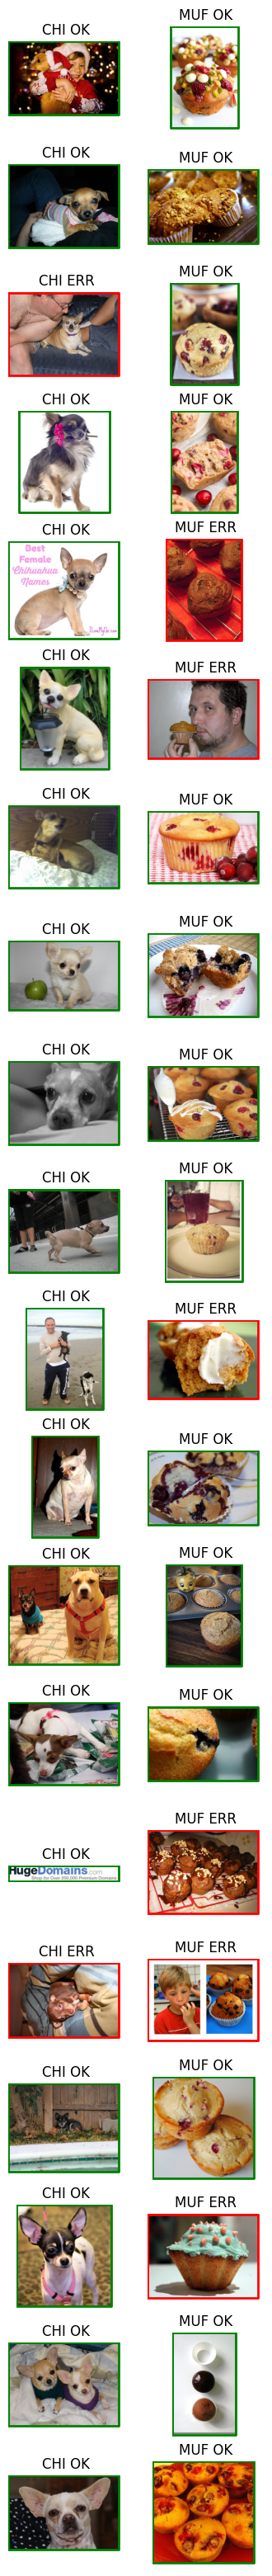

In [53]:
from matplotlib.image import imread

nelem = 20   # number of elements to show

def show_image(imgpath, frame_color, gray=True):
    im = imread(imgpath)
    if gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(4,40))
no = 1  # index current of subfigure
for ii in range(nelem):
    plt.subplot(nelem, 2, 2*ii+1)
    val_img_i = val_imgs_chi[ii]
    x_val_i = x_val_chi[ii]
    y_pred_i = clf.predict(x_val_i.reshape(1,-1))
    expected = 0; classname = "CHI"
    show_image(val_img_i, 'g' if y_pred_i == expected else 'r')
    plt.title(classname + " " + ("OK" if y_pred_i == expected else "ERR"))
    
    plt.subplot(nelem, 2, 2*ii+2)
    val_img_i = val_imgs_muf[ii]
    x_val_i = x_val_muf[ii]
    y_pred_i = clf.predict(x_val_i.reshape(1,-1))
    expected = 1; classname = "MUF"
    show_image(val_img_i, 'g' if y_pred_i == expected else 'r')
    plt.title(classname + " " + ("OK" if y_pred_i == expected else "ERR"))

plt.show()

# 8. Test on meme images
Time for fun: let's test our classifier on the meme images.

In [54]:
meme_test_sifts = !ls $PATH_TO_RESOURCES/meme_siftgeo/*.siftgeo | sort
meme_test_sifts

['/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-1.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-2.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-3.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-4.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-5.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-6.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-7.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/chihuahua-8.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-1.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-2.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-3.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-4.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-5.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-6.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-7.siftgeo',
 '/home/scott/epita/mlrf/tp5/meme_siftgeo/muffin-8.siftgeo']

In [55]:
meme_test_imgs = !ls $PATH_TO_RESOURCES/meme_jpg/*.j*g | sort
meme_test_imgs

['/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-1.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-2.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-3.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-4.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-5.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-6.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-7.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/chihuahua-8.jpg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-1.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-2.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-3.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-4.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-5.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-6.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-7.jpeg',
 '/home/scott/epita/mlrf/tp5/meme_jpg/muffin-8.jpeg']

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the descriptors for each image.**
</div>

In [56]:
x_meme_test = compute_descriptors(meme_test_sifts, train_mean, pca_transform, kmeans)
print(x_meme_test.shape)

Indexing ['meme_siftgeo', 'chihuahua-1.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-2.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-3.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-4.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-5.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-6.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-7.siftgeo']
Indexing ['meme_siftgeo', 'chihuahua-8.siftgeo']
Indexing ['meme_siftgeo', 'muffin-1.siftgeo']
Indexing ['meme_siftgeo', 'muffin-2.siftgeo']
Indexing ['meme_siftgeo', 'muffin-3.siftgeo']
Indexing ['meme_siftgeo', 'muffin-4.siftgeo']
Indexing ['meme_siftgeo', 'muffin-5.siftgeo']
Indexing ['meme_siftgeo', 'muffin-6.siftgeo']
Indexing ['meme_siftgeo', 'muffin-7.siftgeo']
Indexing ['meme_siftgeo', 'muffin-8.siftgeo']
Indexing complete.
(16, 512)


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the target values for the `x_meme_test` vector you created.**
</div>

In [58]:
# TODO
y_true_meme_test = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
y_true_meme_test

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

We can compute the score of our classifier on this little sample

In [59]:
clf.score(x_meme_test, y_true_meme_test)

0.8125

We will now display the results for the meme images.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the predicted values for all meme images.**
</div>

In [60]:
# TODO
y_pred_meme_test = clf.predict(x_meme_test)
y_pred_meme_test

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

Here is a little code to render the results

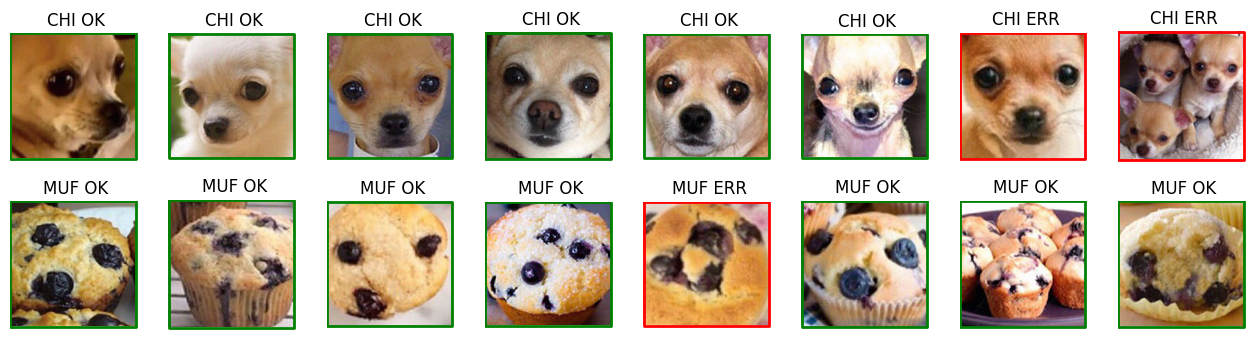

In [61]:
plt.figure(figsize=(16,4))
for ii, (img, y_pred, y_true) in enumerate(zip(meme_test_imgs, y_pred_meme_test, y_true_meme_test)):
    plt.subplot(2, 8, ii+1)
    correct = y_pred == y_true
    show_image(img, 'g' if correct else 'r')
    plt.title(("CHI" if y_true == 0 else "MUF") + " " + ("OK" if correct else "ERR"))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Can you tell anything about the performance of your system based on these results?**
</div>

The images are mostly correctly classified, with the titles indicating "OK" for each image, it suggests that the classifier is performing well on the meme test set.

## 9. Compute the results on the test set and export them
You are now ready to process the test data and submit them for grading.

In [62]:
test_sift_files = !ls $PATH_TO_RESOURCES/test_set_sift/*.siftgeo | sort
test_sift_files[:5]

['/home/scott/epita/mlrf/tp5/test_set_sift/test_0000.siftgeo',
 '/home/scott/epita/mlrf/tp5/test_set_sift/test_0001.siftgeo',
 '/home/scott/epita/mlrf/tp5/test_set_sift/test_0002.siftgeo',
 '/home/scott/epita/mlrf/tp5/test_set_sift/test_0003.siftgeo',
 '/home/scott/epita/mlrf/tp5/test_set_sift/test_0004.siftgeo']

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the BoVW descriptors for each `.siftgeo` file, compute the predicted class, and build the map of results `{test_id: class_name}`.**
</div>

In [63]:
# TODO compute the descriptors for the test set
x_test = compute_descriptors(test_sift_files, train_mean, pca_transform, kmeans)

Indexing ['test_set_sift', 'test_0000.siftgeo']
Indexing ['test_set_sift', 'test_0001.siftgeo']
Indexing ['test_set_sift', 'test_0002.siftgeo']
Indexing ['test_set_sift', 'test_0003.siftgeo']
Indexing ['test_set_sift', 'test_0004.siftgeo']
Indexing ['test_set_sift', 'test_0005.siftgeo']
Indexing ['test_set_sift', 'test_0006.siftgeo']
Indexing ['test_set_sift', 'test_0007.siftgeo']
Indexing ['test_set_sift', 'test_0008.siftgeo']
Indexing ['test_set_sift', 'test_0009.siftgeo']
Indexing ['test_set_sift', 'test_0010.siftgeo']
Indexing ['test_set_sift', 'test_0011.siftgeo']
Indexing ['test_set_sift', 'test_0012.siftgeo']
Indexing ['test_set_sift', 'test_0013.siftgeo']
Indexing ['test_set_sift', 'test_0014.siftgeo']
Indexing ['test_set_sift', 'test_0015.siftgeo']
Indexing ['test_set_sift', 'test_0016.siftgeo']
Indexing ['test_set_sift', 'test_0017.siftgeo']
Indexing ['test_set_sift', 'test_0018.siftgeo']
Indexing ['test_set_sift', 'test_0019.siftgeo']
Indexing ['test_set_sift', 'test_0020.si

Indexing ['test_set_sift', 'test_0181.siftgeo']
Indexing ['test_set_sift', 'test_0182.siftgeo']
Indexing ['test_set_sift', 'test_0183.siftgeo']
Indexing ['test_set_sift', 'test_0184.siftgeo']
Indexing ['test_set_sift', 'test_0185.siftgeo']
Indexing ['test_set_sift', 'test_0186.siftgeo']
Indexing ['test_set_sift', 'test_0187.siftgeo']
Indexing ['test_set_sift', 'test_0188.siftgeo']
Indexing ['test_set_sift', 'test_0189.siftgeo']
Indexing ['test_set_sift', 'test_0190.siftgeo']
Indexing ['test_set_sift', 'test_0191.siftgeo']
Indexing ['test_set_sift', 'test_0192.siftgeo']
Indexing ['test_set_sift', 'test_0193.siftgeo']
Indexing ['test_set_sift', 'test_0194.siftgeo']
Indexing ['test_set_sift', 'test_0195.siftgeo']
Indexing ['test_set_sift', 'test_0196.siftgeo']
Indexing ['test_set_sift', 'test_0197.siftgeo']
Indexing ['test_set_sift', 'test_0198.siftgeo']
Indexing ['test_set_sift', 'test_0199.siftgeo']
Indexing ['test_set_sift', 'test_0200.siftgeo']
Indexing ['test_set_sift', 'test_0201.si

Indexing ['test_set_sift', 'test_0357.siftgeo']
Indexing ['test_set_sift', 'test_0358.siftgeo']
Indexing ['test_set_sift', 'test_0359.siftgeo']
Indexing ['test_set_sift', 'test_0360.siftgeo']
Indexing ['test_set_sift', 'test_0361.siftgeo']
Indexing ['test_set_sift', 'test_0362.siftgeo']
Indexing ['test_set_sift', 'test_0363.siftgeo']
Indexing ['test_set_sift', 'test_0364.siftgeo']
Indexing ['test_set_sift', 'test_0365.siftgeo']
Indexing ['test_set_sift', 'test_0366.siftgeo']
Indexing ['test_set_sift', 'test_0367.siftgeo']
Indexing ['test_set_sift', 'test_0368.siftgeo']
Indexing ['test_set_sift', 'test_0369.siftgeo']
Indexing ['test_set_sift', 'test_0370.siftgeo']
Indexing ['test_set_sift', 'test_0371.siftgeo']
Indexing ['test_set_sift', 'test_0372.siftgeo']
Indexing ['test_set_sift', 'test_0373.siftgeo']
Indexing ['test_set_sift', 'test_0374.siftgeo']
Indexing ['test_set_sift', 'test_0375.siftgeo']
Indexing ['test_set_sift', 'test_0376.siftgeo']
Indexing ['test_set_sift', 'test_0377.si

In [64]:
# TODO compute the predicted classes for the test set
y_test_pred = clf.predict(x_test)

The code below create the structure of the result file automatically, given the source files of the test set and the predictions your system made.

In [65]:
# here is an utility fonction to extract the appropriate part from the path to generate the result id
def path_to_id(path):
    return path[-(9+8):-8]

assert(path_to_id(test_sift_files[0]) == 'test_0000')

In [66]:
results = {path_to_id(f):("chi" if y == 0 else "muf") for f,y in zip(test_sift_files, y_test_pred)}
results

{'test_0000': 'chi',
 'test_0001': 'muf',
 'test_0002': 'chi',
 'test_0003': 'muf',
 'test_0004': 'muf',
 'test_0005': 'muf',
 'test_0006': 'chi',
 'test_0007': 'chi',
 'test_0008': 'chi',
 'test_0009': 'muf',
 'test_0010': 'chi',
 'test_0011': 'chi',
 'test_0012': 'chi',
 'test_0013': 'muf',
 'test_0014': 'chi',
 'test_0015': 'muf',
 'test_0016': 'muf',
 'test_0017': 'chi',
 'test_0018': 'chi',
 'test_0019': 'chi',
 'test_0020': 'chi',
 'test_0021': 'muf',
 'test_0022': 'muf',
 'test_0023': 'muf',
 'test_0024': 'chi',
 'test_0025': 'chi',
 'test_0026': 'chi',
 'test_0027': 'chi',
 'test_0028': 'muf',
 'test_0029': 'muf',
 'test_0030': 'chi',
 'test_0031': 'chi',
 'test_0032': 'muf',
 'test_0033': 'chi',
 'test_0034': 'muf',
 'test_0035': 'chi',
 'test_0036': 'muf',
 'test_0037': 'muf',
 'test_0038': 'chi',
 'test_0039': 'muf',
 'test_0040': 'muf',
 'test_0041': 'muf',
 'test_0042': 'muf',
 'test_0043': 'muf',
 'test_0044': 'chi',
 'test_0045': 'muf',
 'test_0046': 'chi',
 'test_0047':

In [67]:
with open("results.json", 'w') as outfile:
    json.dump(results, outfile, indent=1)
!head results.json

{
 "test_0000": "chi",
 "test_0001": "muf",
 "test_0002": "chi",
 "test_0003": "muf",
 "test_0004": "muf",
 "test_0005": "muf",
 "test_0006": "chi",
 "test_0007": "chi",
 "test_0008": "chi",


The final file should have a content like:
```json
{
 'test_0000': 'chi',
 'test_0001': 'muf',
 'test_0002': 'muf',
 ...
}
```

# Job done!
You completed this session, congratulations!

**Do not forget to submit your `results.json` and `*.ipynb` files!**